<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Titanic/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, I practice python with Titanic Dataset. Manual preprocessing of train and Test data (dropping, endoding categorical values, standardizing columns)


In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
from scipy.stats import shapiro
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Pipeline
1. Age -> fillna() with mean
2. Drop columns:
  Cabin
  Name
  Ticket
  PassengerId
3. Check any Nans
4. Encode Categorical data ('Sex' & 'Embarked')
5. int64, float64 -> int32, float32
6. Standardize colums:
  Age
7. Check the same features order in train and test sets

In [2]:
def nan_percentage(df, colname):
  return (df[colname].isnull().sum() / df.shape[0]) * 100

def standardize_col(df, cols):
  for col in cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [3]:
def remove_outliers(df, col):
  Q1 = np.quantile(df[col], 0.25)
  Q3 = np.quantile(df[col], 0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  print(f'lower = {lower}, upper = {upper}, IQR = {IQR}')

  # after filtering, keep only data within [lower, upper]
  filtered_vals = [x for x in df[col] if (x > lower) & (x < upper)]
  return df.loc[df[col].isin(filtered_vals)]

In [4]:
# Setting file download from google Drive

drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/1.Titanic/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"

Mounted at /content/gdrive


In [5]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [6]:
# Step 1. General Summary
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# Step 2. Check Nan values in any columns
print(f'Any nan? {train.isnull().values.any()}')
nan_cols = train.loc[:, train.isnull().any()].columns

Any nan? True


In [8]:
for col in nan_cols:
  print(f'Column {col} has {nan_percentage(train, col):.2f} % of Nans')

Column Age has 19.87 % of Nans
Column Cabin has 77.10 % of Nans
Column Embarked has 0.22 % of Nans


In [9]:
# Found, that Cabin has 77% of Nans -> remove the column
# Age -> substitute with average / median
# Name, Ticket -> can drop the column
train['Age'].fillna(value=train['Age'].mean(), inplace=True)
train.drop(columns=['Cabin'], inplace=True)
train.drop(columns = ['Name'], inplace=True)
train.drop(columns = ['Ticket'], inplace=True)
train.drop(columns = ['PassengerId'], inplace=True)

In [10]:
# Embarked - nominative variable, cannot fill with mean. 
# Remove the rows where Embarked is Nan
train.drop(index=[61, 829], axis=1, inplace=True)
train.loc[train['Embarked'].isnull(),]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [11]:
# Check, any Nans remained
train.isnull().values.any()

False

In [12]:
# Step 2. Encode categorical values
# We have categorical values "Sex", "Embarked" and "Ticket"
numerical_values = {
    "Sex": {'male': 0, 'female': 1},
    "Embarked": {'S': 0, 'C': 1, 'Q': 2},
}

train.replace(numerical_values, inplace=True)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    int64  
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 62.5 KB
None


In [13]:
# Step3. Int64 to Int32
cols_to_transfer = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
train[cols_to_transfer] = train[cols_to_transfer].astype('int32')

In [14]:
# Step3. Float64 to Float32
cols_to_transfer_float = ['Age', 'Fare']
train[cols_to_transfer_float] = train[cols_to_transfer_float].astype('float32')

In [15]:
# Step 4. Check outliers with IQR analysis
print(f'Before removing outliers, shape = {train.shape}')
train = remove_outliers(train, 'Age')
train = remove_outliers(train, 'Fare')
print(f'After removing outliers, shape = {train.shape}')

Before removing outliers, shape = (889, 8)
lower = 2.5, upper = 54.5, IQR = 13.0
lower = -25.287050008773804, upper = 63.20055031776428, IQR = 22.12190008163452
After removing outliers, shape = (718, 8)


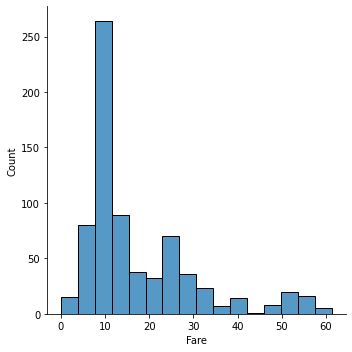

In [16]:
# Step 5. Now we try to standartize features, which are presumably
# from Normal distribution (check it with Shapiro-Wilk test)

train['Fare'].value_counts()
sns.displot(train, x='Fare')

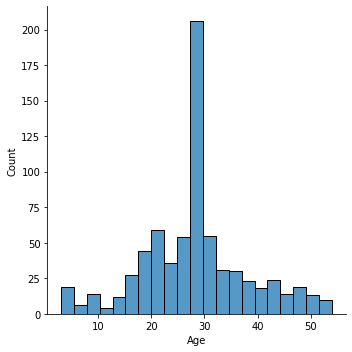

In [17]:
sns.displot(train, x='Age')

In [18]:
# Shapiro test indicates normal dist of Age -> standardize values
shapiro(train['Age'].values)
standardize_col(train, ['Age'])
train['Age']

0     -0.644054
2     -0.245430
3      0.651474
4      0.651474
5      0.123209
         ...   
886   -0.145774
887   -0.943022
888    0.123209
889   -0.245430
890    0.352506
Name: Age, Length: 718, dtype: float32

In [19]:
# Final processed data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  718 non-null    int32  
 1   Pclass    718 non-null    int32  
 2   Sex       718 non-null    int32  
 3   Age       718 non-null    float32
 4   SibSp     718 non-null    int32  
 5   Parch     718 non-null    int32  
 6   Fare      718 non-null    float32
 7   Embarked  718 non-null    int32  
dtypes: float32(2), int32(6)
memory usage: 48.0 KB


In [20]:
Y = train['Survived'].values
X = train.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values

In [21]:
grid = {
    'C': [0.1, 1.0, 5.0],
    'penalty': ['l1', 'l2']
}

# Build model.
# 1st trial - Linear Regressor
model_1 = LogisticRegression()

logreg_cv = GridSearchCV(model_1, grid, cv=5)
logreg_cv.fit(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1.0, 5.0], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
logreg_cv.best_params_, logreg_cv.best_score_

({'C': 1.0, 'penalty': 'l2'}, 0.7827700077700078)

In [23]:
# Processing of test data according to the same pipeline
# Step 1.
test['Age'].fillna(value=test['Age'].mean(), inplace=True)

In [24]:
# Step 2.
test.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'], inplace=True)

In [25]:
# Step 3 - Check Nans
print(test.isnull().values.any())
for col in test.columns:
  print(test[col].isnull().values.any(), col)

nan_percentage(test, 'Fare')
test['Fare'].fillna(value=test['Fare'].median(), inplace=True)

True
False Pclass
False Sex
False Age
False SibSp
False Parch
True Fare
False Embarked


In [26]:
# Step 4. Encode 'Sex' & 'Embarked'
test.replace(numerical_values, inplace=True)

In [27]:
# Step 5. Downsize the data type
# Step3. Int64 to Int32
# Step3. Int64 to Int32
cols_to_transfer = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
test[cols_to_transfer] = test[cols_to_transfer].astype('int32')

In [28]:
print(test.isnull().values.any())

False


In [29]:
# Step 6. Standardize Age
standardize_col(test, ['Age'])

In [30]:
X_test = test.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].values
Y_test = logreg_cv.predict(X_test)

In [32]:
submission = pd.read_csv(test_path)
submission.head()
submission.drop(columns=['Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Pclass', 'Ticket', 'Fare', 'Cabin', 'Embarked'], inplace=True)

In [33]:
submission['Survived'] = Y_test

In [34]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [35]:
# Saving the submission data to csv file
submission.to_csv(gdrive_path + df_path + "submission.csv", index=False)